### Table of Contents

* [I. Creating The Embbeding](#chapter1)
    * [1. Word to pre-trained Embedding](#section_1_1)
    * [2. Building our vocabulary](#section_1_2)
    * [3. Building the embedding matrix](#section_1_3)
    * [4. Embedding our tweets](#section_1_4)
    * [5. Puting all together](#section_1_5)
* [II. Preparing the data](#chapter2)
    * [1. Loading the data](#section_2_1)
    * [2. Making the glove embedding](#section_2_2)
* [III. Machine Learning Classification Models](#chapter3)
    * [1. Naive Bayes](#section_3_1)
    * [2. Logistic Regression](#section_3_2)
    * [3. Random Forest](#section_3_3)
    * [4. SVM](#section_3_4)
* [IV. Making the predictions for Submission](#chapter4)

In [38]:
import sys

sys.path.insert(1, '/Users/douglasbouchet/M1/ML/ml_project_2_sentwiment/src')

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from evaluate import model_Evaluate
from load_utils import load_df


### I. Creating The Embbeding <a class="anchor" id="chapter1"></a>

#### 1. Word to pre-trained Embedding  <a class="anchor" id="section_1_1"></a>

In [39]:
def build_dict_w2v(dim=200):
    """Build a dictionary that map each word existing in the pre-trained embedding to
    its vector representation

    Args:
        dim (int, optional): the dimension of the embedding (25,50,100,200). Defaults to 200.

    Returns:
        [dict]: dictionary mapping words to their embedded version
    """
    # for each word present in the pre_trained embedding, we put its embedding inside a dict
    dict_w2v = {}
    with open('../data/word_Embeddings/pre_trained_glove_embedding/glove.twitter.27B.' + str(dim) + 'd.txt', "r") as file:
        for line in file:
            tokens = line.split()
            word = tokens[0]
            vector = np.array(tokens[1:], dtype=np.float32)
            # only append if the size of the embedding is correct (1 or 2 error in the original file)
            if vector.shape[0] == dim:
                dict_w2v[word] = vector

    print("Dictionary Size: ", len(dict_w2v))
    return dict_w2v

#### 2. Building our vocabulary  <a class="anchor" id="section_1_2"></a>

In [40]:

def build_vocab(df):
    """Build the vocabulary, for our dataframe (i.e mapping from word present in our dataframe
    to their embedding.
    Also compute the index of each word inside the vocabulary (usefull to compute the embedding of
    a given word)

    Args:
        df ([Dataframe]): the dataframe containing the tweet we want to train on (and test)

    Returns:
        [(dict, dict)]: the vocabulary, and the index of each word in the vocabulary
    """
    # we make a dict of all words present in our dataframe
    vocab = {''} 
    for tweet in df.tweet:
        for word in tweet.split(" "):
            vocab.add(word)
    vocab = list(vocab)
    # then for each word, we build a dict for getting its index inside the vocavulary
    word2loc = {}
    for i, word in enumerate(vocab):
        word2loc[word] = i

    return vocab, word2loc

#### 3. Building the embedding matrix  <a class="anchor" id="section_1_3"></a>

In [41]:
def build_embedding_matrix(vocab, df, dict_w2v, word2loc, dim=200):
    """Build the embedding matrix for our dataframe.
    If the embedding of a word does not exist, we set the embedding to 0's(dim) by default

    Args:
        vocab ([dict]): the words present in the glove embedding
        df ([Dataframe]): the dataframe we want to embedd
        dict_w2v ([dict]): each word to its embedding
        word2loc ([dict]): each word to its index
        dim (int, optional): dimension of the embedding(25,50,100,200). Defaults to 200.

    Returns:
        [numpy.ndarray]: the matrix of the embedding
    """

    # For each word of our vocabulary, we have an embedding of "dim" size
    embedding_matrix = np.zeros((len(vocab), dim))
    unk_cnt = 0
    n_words = 0
    # for each tweet/words of our dataframe, we precompute its embedding
    for tweet in df.tweet:
        for word in tweet.split(" "):
            n_words += 1
            embedding_vector = dict_w2v.get(word)
            if embedding_vector is not None:
                embedding_matrix[word2loc[word]] = embedding_vector
            else:
                unk_cnt += 1

    print("Unknown words: ", unk_cnt/n_words*100, "%")

    return embedding_matrix

#### 4. Embedding our tweets  <a class="anchor" id="section_1_2"></a>

In [42]:
def build_embedded_tweets(df, embedding_matrix, word2loc, dim=200):
    """Put all our tweet into their embedding form. 
    We also average each tweet by the embedding of all words of this tweet.
    Thus all our tweet will have the same length of dim, regardless of their initial 
    number of words

    Args:
        df ([Dataframe]): the dataframe we want to embedd
        embedding_matrix ([numpy.ndarray]): matrix that map each word to its embedding
        dim (int, optional): dimension of the embedding(25,50,100,200). Defaults to 200.
        word2loc ([dict]): each word to its index

    Returns:
        [numpy.ndarray]: each row 'i' (of size dim) of the matrix is the embedding of the i'th tweet 
        of the dataframe
    """

    # the embedded matrix is of size #tweets x #embedding size
    embedded = np.zeros((len(df.tweet), dim))
    for i, tweet in enumerate(df.tweet):
        sentence = []
        # for each word of our tweet, we get its embedding
        for word in tweet.split(" "):
            sentence.append(embedding_matrix[word2loc[word]])
        # next we average the embedding of the tweets with value of embedding of each of its words
        # thus each tweet is represented only by a dim embedding
        embedded[i] = np.mean(sentence, axis=0)

    return embedded

#### 5. Puting all together  <a class="anchor" id="section_1_5"></a>

In [43]:
def make_glove_embedding(df, test_size=0.2, dim=200, test=False):
    """Given a dataframe, perfom the glove embedding in the given dimension of all the tweets 
    of this dataframe. Also split the data in training and validating parts.

    Args:
        df ([Dataframe]): the dataframe we want to embedd
        test_size (float, optional): The ratio of the validating set over all. Defaults to 0.2.
        dim (int, optional): dimension of the embedding(25,50,100,200). Defaults to 200.

    Returns:
        [(numpy.ndarray*4)]: first array correspond to the train_data, next valid_data, next 
        valid_data, and valid_label
    """

    dict_w2v = build_dict_w2v(dim)
    vocab, word2loc = build_vocab(df)
    embedding_matrix = build_embedding_matrix(vocab, df, dict_w2v, word2loc)
    embedded = build_embedded_tweets(df, embedding_matrix, word2loc)
    if(test == False):
        return train_test_split(embedded, df.positive, test_size=test_size, random_state=26105111)
    else:
        return embedded

### II. Preparing the data <a class="anchor" id="chapter2"></a>

#### 1. Loading the data  <a class="anchor" id="section_2_1"></a>

In [44]:
# load the dataframe with all tweets and lemmatize
df = load_df(full=True, lemmatize=True)

#### 2. Making the glove embedding  <a class="anchor" id="section_2_2"></a>

In [45]:
# on the full dataset, this task should take 3 minutes 
train_data,valid_data,train_label,valid_label = make_glove_embedding(df)
train_data.shape , valid_data.shape , train_label.shape , valid_label.shape

Dictionary Size:  1193514
Unknown words:  4.4754059564343756 %


((1966637, 200), (491660, 200), (1966637,), (491660,))

### III. Machine Learning Classification Models <a class="anchor" id="chapter3"></a>

#### 1. Bernoulli Naive Baye  <a class="anchor" id="section_3_1"></a>

              precision    recall  f1-score   support

          -1       0.69      0.54      0.61    247987
           1       0.62      0.76      0.68    243673

    accuracy                           0.65    491660
   macro avg       0.66      0.65      0.64    491660
weighted avg       0.66      0.65      0.64    491660



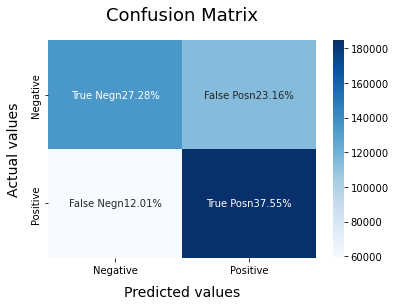

In [46]:
BNBmodel = BernoulliNB()
BNBmodel.fit( train_data,  train_label)
model_Evaluate(BNBmodel,  valid_data,  valid_label)

#### 2. Logistic Regression  <a class="anchor" id="section_3_2"></a>

/Users/douglasbouchet/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

          -1       0.79      0.77      0.78    247987
           1       0.77      0.80      0.78    243673

    accuracy                           0.78    491660
   macro avg       0.78      0.78      0.78    491660
weighted avg       0.78      0.78      0.78    491660



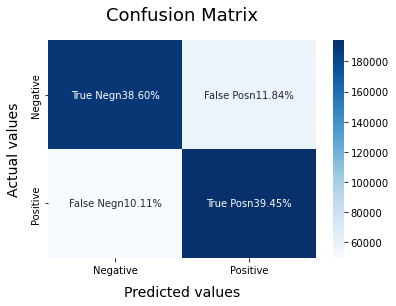

In [47]:
LogisticModel = LogisticRegression()
LogisticModel.fit( train_data,  train_label)
model_Evaluate(LogisticModel,  valid_data,  valid_label)

#### 3. RandomForest Classifier  <a class="anchor" id="section_3_3"></a>

              precision    recall  f1-score   support

          -1       0.76      0.58      0.66    247987
           1       0.65      0.81      0.72    243673

    accuracy                           0.69    491660
   macro avg       0.71      0.69      0.69    491660
weighted avg       0.71      0.69      0.69    491660



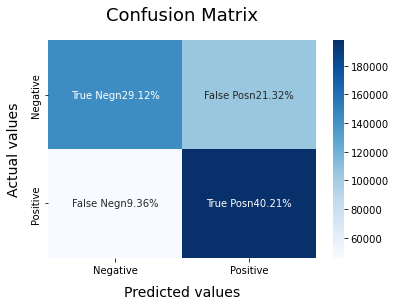

In [48]:
# this should take arounf 10 minutes for the full dataset
clf_rdf = RandomForestClassifier(max_depth=3, bootstrap=True, n_jobs=-1, min_samples_leaf=5)
clf_rdf.fit( train_data,  train_label)
model_Evaluate(clf_rdf,  valid_data,  valid_label)

#### 4. Linear SVM  <a class="anchor" id="section_3_4"></a>

For the SVM classifier, we use only the 100 000 first tweets for the training because of time expensiveness
of the SVM training process in the number of data points used to create the margins. Although, it gives quite 
good results

/Users/douglasbouchet/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.79      0.76      0.77    247987
           1       0.76      0.80      0.78    243673

    accuracy                           0.78    491660
   macro avg       0.78      0.78      0.78    491660
weighted avg       0.78      0.78      0.78    491660



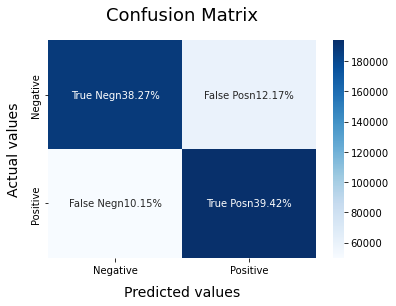

In [49]:
train_data  =  train_data[0:20000]
train_label =  train_label[0:20000]
lin_clf = svm.LinearSVC()
lin_clf.fit(train_data, train_label)
model_Evaluate(lin_clf, valid_data, valid_label)

### IV. Making the predictions for Submission <a class="anchor" id="chapter4"></a>

In [50]:
data_test = pd.read_csv('../data/data_submission_preprocessed.csv')
x_test = make_glove_embedding(data_test, test_size=0.0, test=True)

predictions = lin_clf.predict(x_test)
#We rename the Id column in order to be accepted in the submission platform
data_test = data_test.rename(columns={'tweet_idx':'Id'})
# We add the prections column
data_test['Prediction'] = predictions
# We save to a csv file only Id, Prediction columns
data_test[['Id', 'Prediction']].to_csv('../submission.csv', encoding='utf-8', index=False)


Dictionary Size:  1193514
Unknown words:  4.529038620432314 %
